In [1]:
from statsmodels.regression.rolling import RollingOLS
import pandas_datareader.data as web
import matplotlib.pyplot as plt
import statsmodels.api as sm
import pandas as pd
import numpy as np
import yfinance as yf
import datetime as dt
import talib
import warnings
warnings.filterwarnings('ignore')

In [2]:
sp500 = pd.read_html('https://en.wikipedia.org/wiki/List_of_S%26P_500_companies')[0]

In [3]:
sp500['Symbol'] = sp500['Symbol'].str.replace('.','-')
symbols_list = sp500['Symbol'].unique().tolist()

In [4]:
end_date = '2025-06-1'
start_date = pd.to_datetime(end_date) - pd.DateOffset(365*8)

In [5]:
df = yf.download(tickers=symbols_list,
                 start=start_date,
                 end=end_date)

[*********************100%***********************]  503 of 503 completed


In [6]:
df = df.stack()

In [7]:
df.index.names= ['date','ticker']

In [8]:
df.columns = df.columns.str.lower()

In [9]:
df

Price                   close        high         low        open       volume
date       ticker                                                             
2017-06-05 A        56.732998   57.146283   56.667248   57.108711    1473300.0
           AAPL     35.854858   35.975983   35.745385   35.950360  101326800.0
           ABBV     47.536835   47.783284   47.093220   47.353755    4918100.0
           ABT      40.265575   40.377857   40.058290   40.222391    7810600.0
           ACGL     31.167286   31.420855   31.094383   31.249697    2004900.0
...                       ...         ...         ...         ...          ...
2025-05-30 XYL     126.040001  126.690002  125.199997  126.519997    2624100.0
           YUM     143.940002  144.479996  143.089996  144.039993    3184400.0
           ZBH      91.931602   92.799355   91.203495   92.699615    3505200.0
           ZBRA    289.769989  290.559998  283.920013  289.929993     656100.0
           ZTS     168.630005  169.789993  165.339996  166.919998    5467800.0

[989599 rows x 5 columns]

## 2. Calculate features and technical indicators

In [10]:
df['garmann_klass_vol'] = ((np.log(df['high']) - np.log(df['low']))**2)/2-(2*np.log(2)-1)*((np.log(df['close']) - np.log(df['open']))**2)
df['rsi'] = df.groupby(level=1)['close'].transform(lambda x: talib.RSI(x.values,timeperiod=20))

df['bb_low']  = df.groupby(level=1)['close'].transform(lambda x: talib.BBANDS(np.log1p(x.values), timeperiod=20)[2])
df['bb_mid']  = df.groupby(level=1)['close'].transform(lambda x: talib.BBANDS(np.log1p(x.values), timeperiod=20)[1])
df['bb_high'] = df.groupby(level=1)['close'].transform(lambda x: talib.BBANDS(np.log1p(x.values), timeperiod=20)[0])

def compute_atr(stock_data):
    atr = talib.ATR(stock_data['high'].values,
                    stock_data['low'].values,
                    stock_data['close'].values,
                    timeperiod=14)
    atr = pd.Series(atr, index=stock_data.index)  # reattach index for alignment
    return (atr - atr.mean()) / atr.std()

df['atr'] = df.groupby(level=1, group_keys=False).apply(compute_atr)

def compute_macd(close):
    macd, signal, hist = talib.MACD(close.values, fastperiod=12, slowperiod=26, signalperiod=9)
    macd = pd.Series(macd, index=close.index)  # maintain alignment
    return (macd - macd.mean()) / macd.std()

df['macd'] = df.groupby(level=1, group_keys=False)['close'].apply(compute_macd)

df['dollar_volume'] = (df['close'] * df['volume'])/1e6

df

Price                   close        high         low        open  \
date       ticker                                                   
2017-06-05 A        56.732998   57.146283   56.667248   57.108711   
           AAPL     35.854858   35.975983   35.745385   35.950360   
           ABBV     47.536835   47.783284   47.093220   47.353755   
           ABT      40.265575   40.377857   40.058290   40.222391   
           ACGL     31.167286   31.420855   31.094383   31.249697   
...                       ...         ...         ...         ...   
2025-05-30 XYL     126.040001  126.690002  125.199997  126.519997   
           YUM     143.940002  144.479996  143.089996  144.039993   
           ZBH      91.931602   92.799355   91.203495   92.699615   
           ZBRA    289.769989  290.559998  283.920013  289.929993   
           ZTS     168.630005  169.789993  165.339996  166.919998   

Price                   volume  garmann_klass_vol        rsi    bb_low  \
date       ticker                                                        
2017-06-05 A         1473300.0           0.000019        NaN       NaN   
           AAPL    101326800.0           0.000018        NaN       NaN   
           ABBV      4918100.0           0.000100        NaN       NaN   
           ABT       7810600.0           0.000031        NaN       NaN   
           ACGL      2004900.0           0.000052        NaN       NaN   
...                        ...                ...        ...       ...   
2025-05-30 XYL       2624100.0           0.000064  57.889330  4.800087   
           YUM       3184400.0           0.000047  44.883265  4.967293   
           ZBH       3505200.0           0.000124  40.059086  4.502665   
           ZBRA       656100.0           0.000267  55.497931  5.520376   
           ZTS       5467800.0           0.000313  59.546814  5.034332   

Price                bb_mid   bb_high       atr      macd  dollar_volume  
date       ticker                                                         
2017-06-05 A            NaN       NaN       NaN       NaN      83.584726  
           AAPL         NaN       NaN       NaN       NaN    3633.058066  
           ABBV         NaN       NaN       NaN       NaN     233.790907  
           ABT          NaN       NaN       NaN       NaN     314.498303  
           ACGL         NaN       NaN       NaN       NaN      62.487292  
...                     ...       ...       ...       ...            ...  
2025-05-30 XYL     4.834142  4.868197  0.308081  1.028506     330.741566  
           YUM     4.990759  5.014225  0.870221 -0.800426     458.362544  
           ZBH     4.558513  4.614362 -0.158387 -0.923067     322.238653  
           ZBRA    5.648873  5.777371  0.168253  0.964343     190.118090  
           ZTS     5.088457  5.142582  0.629476  1.019474     922.035141  

[989599 rows x 13 columns]

## 3. Aggregate to monthly level and filter 150 most liquid stocks for each month

In [11]:
mean_dollar_vol = df.unstack('ticker')['dollar_volume'].resample('M').mean().stack('ticker').to_frame('dollar_volume')

In [12]:
last_cols = [c for c in df.columns.unique(0) if c not in ['dollar_volume', 'volume', 'high','low','open']]

monthly_indicators = df.unstack()[last_cols].resample('M').last().stack('ticker')


In [13]:
data = pd.concat([mean_dollar_vol, monthly_indicators], axis=1).dropna()

Calculate 5-year rolling average of dollar_volume for each stock before filtering

In [14]:
data['dollar_volume'] = (data.loc[:, 'dollar_volume'].unstack('ticker').rolling(5*12, min_periods=12).mean().stack())

data['dollar_vol_rank'] = (data.groupby('date')['dollar_volume'].rank(ascending=False))

data = data[data['dollar_vol_rank']<150].drop(['dollar_volume', 'dollar_vol_rank'], axis=1)

data

close  garmann_klass_vol        rsi    bb_low  \
date       ticker                                                       
2018-06-30 AAPL     43.787838           0.000252  49.582267  3.782213   
           ABBV     67.451653           0.000205  38.080483  4.207378   
           ABT      53.739521           0.000094  47.018601  3.993520   
           ACN     147.388321           0.000113  58.053495  4.953232   
           ADBE    243.809998           0.000110  50.937227  5.474781   
...                       ...                ...        ...       ...   
2025-05-31 VZ       43.260517           0.000085  53.634953  3.758071   
           WDAY    247.710007           0.000227  48.534163  5.453738   
           WFC      74.779999           0.000080  57.092537  4.286886   
           WMT      98.720001           0.000159  58.713276  4.569311   
           XOM     102.300003           0.000069  42.393078  4.620994   

                     bb_mid   bb_high       atr      macd  
date       ticker                                          
2018-06-30 AAPL    3.819717  3.857222 -1.242528 -0.279856  
           ABBV    4.269948  4.332518 -0.773603 -1.003934  
           ABT     4.023272  4.053024 -1.337660 -0.351552  
           ACN     4.985015  5.016799 -0.969057  0.031032  
           ADBE    5.521728  5.568676 -1.120731 -0.111269  
...                     ...       ...       ...       ...  
2025-05-31 VZ      3.780491  3.802911  0.429370  0.060829  
           WDAY    5.556007  5.658276  0.711473  0.016955  
           WFC     4.320663  4.354439  1.448849  1.010874  
           WMT     4.588856  4.608402  2.761345  0.948530  
           XOM     4.662747  4.704499  0.718368 -0.987693  

[12516 rows x 8 columns]

## 4. Calculate monthly returns for different time horizons as features

In [15]:
def calculate_returns(df):

    outlier_cutoff = 0.005

    lags = [1, 2, 3, 6, 9, 12]

    for lag in lags:

        df[f'return_{lag}m'] = (df['close']
                              .pct_change(lag)
                              .pipe(lambda x: x.clip(lower=x.quantile(outlier_cutoff),
                                                     upper=x.quantile(1-outlier_cutoff)))
                              .add(1)
                              .pow(1/lag)
                              .sub(1))
    return df
    
    
data = data.groupby(level=1, group_keys=False).apply(calculate_returns).dropna()

data

close  garmann_klass_vol        rsi    bb_low  \
date       ticker                                                       
2019-06-30 AAPL     47.530727           0.000071  56.282133  3.781842   
           ABBV     55.443413           0.000223  42.046325  3.974889   
           ABT      75.395195           0.000088  64.665749  4.250443   
           ACN     169.383652           0.000099  58.459487  5.099023   
           ADBE    294.649994           0.000057  58.679794  5.566200   
...                       ...                ...        ...       ...   
2025-05-31 VZ       43.260517           0.000085  53.634953  3.758071   
           WDAY    247.710007           0.000227  48.534163  5.453738   
           WFC      74.779999           0.000080  57.092537  4.286886   
           WMT      98.720001           0.000159  58.713276  4.569311   
           XOM     102.300003           0.000069  42.393078  4.620994   

                     bb_mid   bb_high       atr      macd  return_1m  \
date       ticker                                                      
2019-06-30 AAPL    3.856704  3.931566 -1.103797  0.023162   0.130519   
           ABBV    4.076525  4.178161 -0.416965 -0.931281  -0.052014   
           ABT     4.311102  4.371761 -0.987360  0.935755   0.104689   
           ACN     5.129683  5.160344 -1.072057  0.161059   0.037626   
           ADBE    5.645850  5.725500 -0.887854  0.427627   0.087671   
...                     ...       ...       ...       ...        ...   
2025-05-31 VZ      3.780491  3.802911  0.429370  0.060829  -0.002270   
           WDAY    5.556007  5.658276  0.711473  0.016955   0.011061   
           WFC     4.320663  4.354439  1.448849  1.010874   0.058869   
           WMT     4.588856  4.608402  2.761345  0.948530   0.017570   
           XOM     4.662747  4.704499  0.718368 -0.987693  -0.022605   

                   return_2m  return_3m  return_6m  return_9m  return_12m  
date       ticker                                                          
2019-06-30 AAPL    -0.004965   0.015095   0.039950  -0.013235    0.006858  
           ABBV    -0.042929  -0.029421  -0.032749  -0.024888   -0.016205  
           ABT      0.028136   0.018439   0.026936   0.016743    0.028618  
           ACN      0.005732   0.019101   0.047516   0.011115    0.011659  
           ADBE     0.009291   0.034051   0.045016   0.009775    0.015908  
...                      ...        ...        ...        ...         ...  
2025-05-31 VZ      -0.007679   0.011968   0.004157   0.011156    0.011000  
           WDAY     0.029913  -0.020189  -0.001526  -0.006713    0.013277  
           WFC      0.023408  -0.013502  -0.001336   0.029559    0.020651  
           WMT      0.061706   0.002093   0.012148   0.028495    0.035317  
           XOM     -0.068285  -0.024827  -0.020514  -0.012807   -0.008481  

[10318 rows x 14 columns]

## 5. Download Fama-French Factors and Calculate Rolling-factor betas

In [16]:
factor_data = web.DataReader('F-F_Research_Data_5_Factors_2x3',
              'famafrench', start='2010')[0].drop('RF',axis=1)

In [17]:
factor_data.index = factor_data.index.to_timestamp()
factor_data = factor_data.resample('M').last().div(100)

In [18]:
factor_data

,Mkt-RF,SMB,HML,RMW,CMA
Date,,,,,
2010-01-31,-0.0335,0.0040,0.0033,-0.0108,0.0051
2010-02-28,0.0339,0.0149,0.0318,-0.0029,0.0142
2010-03-31,0.0630,0.0183,0.0219,-0.0061,0.0174
2010-04-30,0.0200,0.0496,0.0296,0.0061,0.0175
2010-05-31,-0.0790,0.0008,-0.0248,0.0130,-0.0024
...,...,...,...,...,...
2025-01-31,0.0280,-0.0122,0.0163,-0.0232,-0.0324
2025-02-28,-0.0243,-0.0491,0.0491,0.0110,0.0306
2025-03-31,-0.0639,-0.0149,0.0290,0.0211,-0.0047


In [19]:
# Step 1: Extract return_1m (MultiIndex: date, ticker)
returns = data['return_1m'] 

# Step 2: Reindex factor_data to match MultiIndex by repeating across tickers
# This matches the index of `returns`
factor_broadcast = factor_data.reindex(returns.index.get_level_values('date')).reset_index()
factor_broadcast.index = returns.index  # Set MultiIndex ['date', 'ticker']

# Step 3: Combine into one DataFrame
factor_data = pd.concat([factor_broadcast, returns], axis=1)

factor_data = factor_data.drop(columns='date')

In [20]:
observations = factor_data.groupby(level=1).size()

valid_stocks = observations[observations >=10]

factor_data = factor_data[factor_data.index.get_level_values('ticker').isin(valid_stocks.index)]

factor_data

Mkt-RF     SMB     HML     RMW     CMA  return_1m
date       ticker                                                   
2019-06-30 AAPL    0.0692  0.0037 -0.0064  0.0089 -0.0042   0.130519
           ABBV    0.0692  0.0037 -0.0064  0.0089 -0.0042  -0.052014
           ABT     0.0692  0.0037 -0.0064  0.0089 -0.0042   0.104689
           ACN     0.0692  0.0037 -0.0064  0.0089 -0.0042   0.037626
           ADBE    0.0692  0.0037 -0.0064  0.0089 -0.0042   0.087671
...                   ...     ...     ...     ...     ...        ...
2025-05-31 VZ      0.0606 -0.0072 -0.0288  0.0127  0.0250  -0.002270
           WDAY    0.0606 -0.0072 -0.0288  0.0127  0.0250   0.011061
           WFC     0.0606 -0.0072 -0.0288  0.0127  0.0250   0.058869
           WMT     0.0606 -0.0072 -0.0288  0.0127  0.0250   0.017570
           XOM     0.0606 -0.0072 -0.0288  0.0127  0.0250  -0.022605

[10241 rows x 6 columns]

In [21]:
betas = (factor_data.groupby(level=1,
                            group_keys=False)
         .apply(lambda x: RollingOLS(endog=x['return_1m'], 
                                     exog=sm.add_constant(x.drop('return_1m', axis=1)),
                                     window=min(24, x.shape[0]),
                                     min_nobs=len(x.columns)+1)
         .fit(params_only=True)
         .params
         .drop('const', axis=1)))

betas

Mkt-RF       SMB       HML       RMW       CMA
date       ticker                                                  
2019-06-30 AAPL         NaN       NaN       NaN       NaN       NaN
           ABBV         NaN       NaN       NaN       NaN       NaN
           ABT          NaN       NaN       NaN       NaN       NaN
           ACN          NaN       NaN       NaN       NaN       NaN
           ADBE         NaN       NaN       NaN       NaN       NaN
...                     ...       ...       ...       ...       ...
2025-05-31 VZ      0.847747 -1.090035  1.035091  0.603547 -0.414252
           WDAY    1.256783 -1.154695  0.450931 -1.696574 -0.051403
           WFC     0.883767 -0.057457  0.437661 -1.667752  0.069468
           WMT     0.522420  0.128990 -0.531404  0.049589 -0.644710
           XOM     0.406687 -0.307039  1.132699  1.104189 -0.251744

[10241 rows x 5 columns]

In [22]:
factors = ['Mkt-RF', 'SMB', 'HML', 'RMW', 'CMA']

data = (data.join(betas.groupby('ticker').shift()))

data.loc[:, factors] = data.groupby('ticker', group_keys=False)[factors].apply(lambda x: x.fillna(x.mean()))

data = data.drop('close', axis=1)

data = data.dropna()

data.info()

<class 'pandas.core.frame.DataFrame'>
MultiIndex: 10112 entries, (Timestamp('2019-06-30 00:00:00'), 'AAPL') to (Timestamp('2025-05-31 00:00:00'), 'XOM')
Data columns (total 18 columns):
 #   Column             Non-Null Count  Dtype  
---  ------             --------------  -----  
 0   garmann_klass_vol  10112 non-null  float64
 1   rsi                10112 non-null  float64
 2   bb_low             10112 non-null  float64
 3   bb_mid             10112 non-null  float64
 4   bb_high            10112 non-null  float64
 5   atr                10112 non-null  float64
 6   macd               10112 non-null  float64
 7   return_1m          10112 non-null  float64
 8   return_2m          10112 non-null  float64
 9   return_3m          10112 non-null  float64
 10  return_6m          10112 non-null  float64
 11  return_9m          10112 non-null  float64
 12  return_12m         10112 non-null  float64
 13  Mkt-RF             10112 non-null  float64
 14  SMB                10112 non-null  float6

## 6. For each month fit a K-means Clustering Algorithm to group similar assets based on their features

In [23]:
from sklearn.preprocessing import StandardScaler

def scale_per_date(group):
    scaler = StandardScaler()
    scaled_values = scaler.fit_transform(group)
    return pd.DataFrame(scaled_values, index=group.index, columns=group.columns)

data_normalized = data.groupby('date', group_keys=False).apply(scale_per_date)


In [24]:
data_normalized

garmann_klass_vol       rsi    bb_low    bb_mid   bb_high  \
date       ticker                                                              
2019-06-30 AAPL            -0.483178  0.077277 -0.644488 -0.621196 -0.597448   
           ABBV             0.783512 -2.035482 -0.437161 -0.384556 -0.331511   
           ABT             -0.335024  1.321503 -0.141224 -0.132032 -0.122727   
           ACN             -0.250520  0.400421  0.770127  0.749177  0.727708   
           ADBE            -0.592852  0.433117  1.271862  1.304836  1.337193   
...                              ...       ...       ...       ...       ...   
2025-05-31 VZ              -0.676451 -0.075772 -1.334544 -1.381191 -1.425529   
           WDAY            -0.082637 -0.736418  0.430833  0.467670  0.503699   
           WFC             -0.695375  0.372048 -0.783990 -0.818705 -0.852044   
           WMT             -0.365716  0.581964 -0.489954 -0.539433 -0.587972   
           XOM             -0.744044 -1.531802 -0.436146 -0.462490 -0.488048   

                        atr      macd  return_1m  return_2m  return_3m  \
date       ticker                                                        
2019-06-30 AAPL   -0.838759 -0.371471   0.854649  -0.025583   0.202545   
           ABBV    1.237093 -2.785028  -2.362718  -1.179657  -1.201542   
           ABT    -0.486845  1.936255   0.399369   0.980672   0.308041   
           ACN    -0.742829 -0.022765  -0.782710   0.299596   0.328915   
           ADBE   -0.186104  0.651321   0.099396   0.407805   0.800450   
...                     ...       ...        ...        ...        ...   
2025-05-31 VZ     -0.681709 -0.406118  -0.592318  -0.378642   0.456314   
           WDAY   -0.379044 -0.435802  -0.443623   0.184725  -0.317224   
           WFC     0.412073  0.236648   0.089625   0.087241  -0.156361   
           WMT     1.820225  0.194469  -0.371023   0.661205   0.218766   
           XOM    -0.371648 -1.115511  -0.819144  -1.286933  -0.428786   

                   return_6m  return_9m  return_12m    Mkt-RF       SMB  \
date       ticker                                                         
2019-06-30 AAPL     0.514262  -0.634321    0.050492  0.464707 -0.290576   
           ABBV    -2.273134  -1.189911   -1.155008 -1.136449  0.043415   
           ABT      0.015271   0.795058    1.187863 -0.558392 -0.316477   
           ACN      0.804336   0.526715    0.301402  0.279324 -0.512664   
           ADBE     0.708474   0.462834    0.523535  0.863782 -1.410554   
...                      ...        ...         ...       ...       ...   
2025-05-31 VZ       0.312557   0.219244    0.118019 -0.142443 -1.280865   
           WDAY     0.116950  -0.351895    0.197207  0.214738 -1.075005   
           WFC      0.123487   0.807452    0.453719 -0.217873  0.070515   
           WMT      0.587594   0.773435    0.963825 -0.357971  0.356596   
           XOM     -0.536597  -0.546695   -0.559577 -0.924135 -0.203923   

                        HML       RMW       CMA  
date       ticker                                
2019-06-30 AAPL   -1.354622  0.485073  0.423634  
           ABBV   -0.325424  0.242001  0.650641  
           ABT    -0.769352 -0.102030  1.054470  
           ACN    -0.631591  0.122044 -0.091557  
           ADBE   -0.591733  0.292179 -0.513044  
...                     ...       ...       ...  
2025-05-31 VZ      0.464671  0.767110  0.116274  
           WDAY   -0.306729 -1.327833 -0.169165  
           WFC     0.191967 -1.201450  0.079632  
           WMT    -0.974121  0.527384  0.657577  
           XOM     0.612014  1.183115  0.238640  

[10112 rows x 18 columns]

In [25]:
from sklearn.cluster import KMeans

def get_clusters(df):
    df['cluster'] = KMeans(n_clusters=4,
                           random_state=0,
                           init='random').fit(df).labels_
    return df

data_normalized = data_normalized.dropna().groupby('date', group_keys=False).apply(get_clusters)

data_normalized

garmann_klass_vol       rsi    bb_low    bb_mid   bb_high  \
date       ticker                                                              
2019-06-30 AAPL            -0.483178  0.077277 -0.644488 -0.621196 -0.597448   
           ABBV             0.783512 -2.035482 -0.437161 -0.384556 -0.331511   
           ABT             -0.335024  1.321503 -0.141224 -0.132032 -0.122727   
           ACN             -0.250520  0.400421  0.770127  0.749177  0.727708   
           ADBE            -0.592852  0.433117  1.271862  1.304836  1.337193   
...                              ...       ...       ...       ...       ...   
2025-05-31 VZ              -0.676451 -0.075772 -1.334544 -1.381191 -1.425529   
           WDAY            -0.082637 -0.736418  0.430833  0.467670  0.503699   
           WFC             -0.695375  0.372048 -0.783990 -0.818705 -0.852044   
           WMT             -0.365716  0.581964 -0.489954 -0.539433 -0.587972   
           XOM             -0.744044 -1.531802 -0.436146 -0.462490 -0.488048   

                        atr      macd  return_1m  return_2m  return_3m  \
date       ticker                                                        
2019-06-30 AAPL   -0.838759 -0.371471   0.854649  -0.025583   0.202545   
           ABBV    1.237093 -2.785028  -2.362718  -1.179657  -1.201542   
           ABT    -0.486845  1.936255   0.399369   0.980672   0.308041   
           ACN    -0.742829 -0.022765  -0.782710   0.299596   0.328915   
           ADBE   -0.186104  0.651321   0.099396   0.407805   0.800450   
...                     ...       ...        ...        ...        ...   
2025-05-31 VZ     -0.681709 -0.406118  -0.592318  -0.378642   0.456314   
           WDAY   -0.379044 -0.435802  -0.443623   0.184725  -0.317224   
           WFC     0.412073  0.236648   0.089625   0.087241  -0.156361   
           WMT     1.820225  0.194469  -0.371023   0.661205   0.218766   
           XOM    -0.371648 -1.115511  -0.819144  -1.286933  -0.428786   

                   return_6m  return_9m  return_12m    Mkt-RF       SMB  \
date       ticker                                                         
2019-06-30 AAPL     0.514262  -0.634321    0.050492  0.464707 -0.290576   
           ABBV    -2.273134  -1.189911   -1.155008 -1.136449  0.043415   
           ABT      0.015271   0.795058    1.187863 -0.558392 -0.316477   
           ACN      0.804336   0.526715    0.301402  0.279324 -0.512664   
           ADBE     0.708474   0.462834    0.523535  0.863782 -1.410554   
...                      ...        ...         ...       ...       ...   
2025-05-31 VZ       0.312557   0.219244    0.118019 -0.142443 -1.280865   
           WDAY     0.116950  -0.351895    0.197207  0.214738 -1.075005   
           WFC      0.123487   0.807452    0.453719 -0.217873  0.070515   
           WMT      0.587594   0.773435    0.963825 -0.357971  0.356596   
           XOM     -0.536597  -0.546695   -0.559577 -0.924135 -0.203923   

                        HML       RMW       CMA  cluster  
date       ticker                                         
2019-06-30 AAPL   -1.354622  0.485073  0.423634        2  
           ABBV   -0.325424  0.242001  0.650641        0  
           ABT    -0.769352 -0.102030  1.054470        3  
           ACN    -0.631591  0.122044 -0.091557        3  
           ADBE   -0.591733  0.292179 -0.513044        3  
...                     ...       ...       ...      ...  
2025-05-31 VZ      0.464671  0.767110  0.116274        1  
           WDAY   -0.306729 -1.327833 -0.169165        2  
           WFC     0.191967 -1.201450  0.079632        1  
           WMT    -0.974121  0.527384  0.657577        2  
           XOM     0.612014  1.183115  0.238640        0  

[10112 rows x 19 columns]

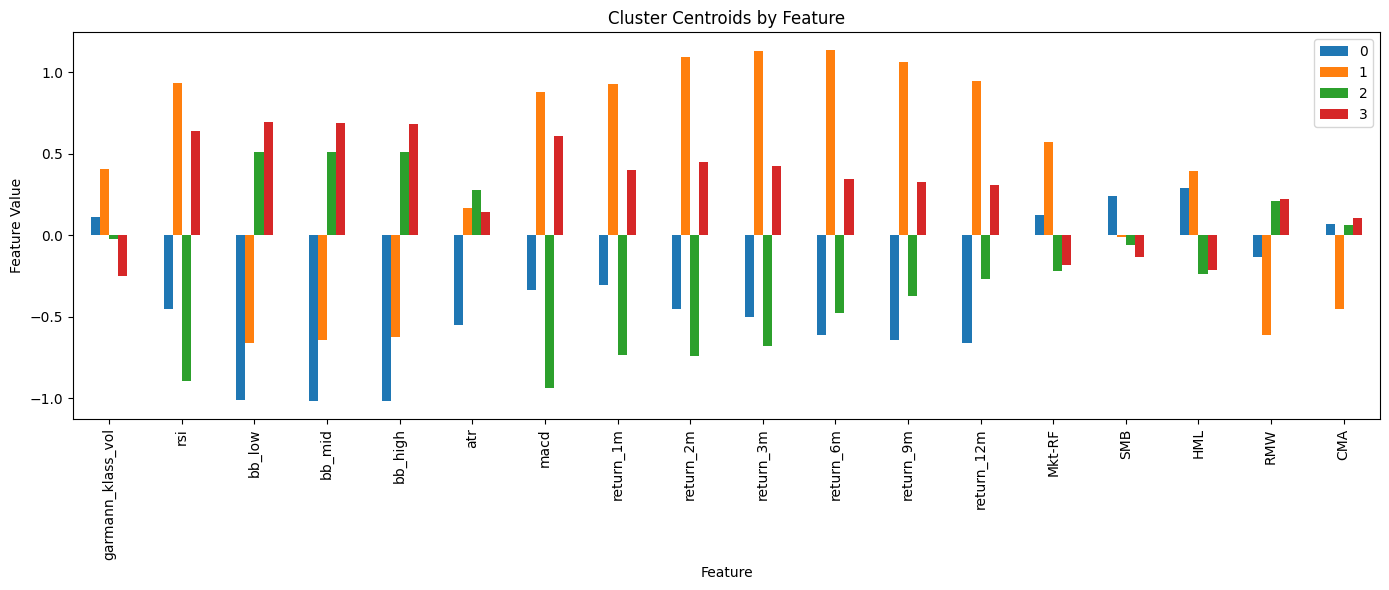

Feature influence (by centroid variance):

rsi                  0.753763
bb_low               0.715414
return_3m            0.710063
bb_mid               0.709537
return_2m            0.707300
macd                 0.705862
bb_high              0.701469
return_6m            0.656935
return_9m            0.583787
return_1m            0.544452
return_12m           0.492977
RMW                  0.152043
atr                  0.141359
Mkt-RF               0.133587
HML                  0.108875
garmann_klass_vol    0.076024
CMA                  0.071414
SMB                  0.026305
dtype: float64


In [26]:
# 3. Refit KMeans on full data (without cluster column)
features = data_normalized.drop(columns='cluster')
kmeans_full = KMeans(n_clusters=4, random_state=0, init='random')
kmeans_full.fit(features)

# 4. Analyze centroids (feature influence)
centroids = pd.DataFrame(kmeans_full.cluster_centers_, columns=features.columns)

# Plot how each feature varies across clusters
centroids.T.plot(kind='bar', figsize=(14, 6), title='Cluster Centroids by Feature')
plt.ylabel("Feature Value")
plt.xlabel("Feature")
plt.tight_layout()
plt.show()

# 5. Rank features by variance across clusters (proxy for influence)
feature_influence = centroids.var(axis=0).sort_values(ascending=False)
print("Feature influence (by centroid variance):\n")
print(feature_influence)

## 7. For each month select assets based on the cluster and form a portfolio based on Efficient Frontier max sharpe ratio optimization

In [44]:
from pypfopt.expected_returns import mean_historical_return
from pypfopt.risk_models import CovarianceShrinkage
from pypfopt.efficient_frontier import EfficientFrontier

portfolio_weights = {}

for date, group in data_normalized.groupby(level=0):
    cluster_returns = group.groupby("cluster")["return_1m"].mean()
    best_cluster = cluster_returns.idxmax()

    selected = group[group["cluster"] == best_cluster]
    tickers_selected = selected.index.get_level_values("ticker")

    past_returns = data.loc[data.index.get_level_values('ticker').isin(tickers_selected)]
    past_returns = past_returns.loc[past_returns.index.get_level_values('date') < date]
    past_returns = past_returns.groupby('ticker').tail(6)

    if past_returns.empty or len(past_returns['return_1m'].dropna().unique()) < 2:
        continue

    returns_df = past_returns.reset_index().pivot(index='date', columns='ticker', values='return_1m')

    # Drop tickers (columns) with any NaNs
    returns_df = returns_df.dropna(axis=1, how='any')

    # Skip if still not enough data
    if returns_df.empty or returns_df.shape[0] < 2 or returns_df.shape[1] < 2:
        continue

    try:
        mu = returns_df.mean()
        S = CovarianceShrinkage(returns_df).ledoit_wolf()
        ef = EfficientFrontier(mu, S)
        weights = ef.max_sharpe()
        cleaned_weights = ef.clean_weights()
        portfolio_weights[date] = cleaned_weights
    except Exception as e:
        print(f"Optimization failed for {date}: {e}")
        continue


Optimization failed for 2020-05-31 00:00:00: Input contains NaN.
Optimization failed for 2020-08-31 00:00:00: Input contains NaN.
Optimization failed for 2021-10-31 00:00:00: Input contains NaN.


In [45]:
portfolio_weights

{Timestamp('2019-08-31 00:00:00'): OrderedDict([('ABT', 0.01695),
              ('ACN', 0.01548),
              ('ADBE', 0.01599),
              ('ADP', 0.01468),
              ('AMGN', 0.01635),
              ('AMT', 0.01409),
              ('AZO', 0.01576),
              ('BA', 0.01373),
              ('BDX', 0.01563),
              ('BKNG', 0.01681),
              ('CHTR', 0.01421),
              ('COST', 0.01699),
              ('CRM', 0.01413),
              ('DHR', 0.01519),
              ('EL', 0.01692),
              ('HD', 0.01664),
              ('HUM', 0.01859),
              ('INTU', 0.01663),
              ('KO', 0.01544),
              ('LLY', 0.01228),
              ('LMT', 0.01526),
              ('LOW', 0.01576),
              ('MA', 0.01554),
              ('MCD', 0.01508),
              ('MDLZ', 0.01497),
              ('MDT', 0.01604),
              ('META', 0.0158),
              ('MRK', 0.01493),
              ('MSFT', 0.01595),
              ('NEE', 0.01469),
   